In [ ]:
import zipfile
from google.colab import drive

import pandas as pd
import numpy as np

import random
import re

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os
import shutil

import librosa
import librosa.display

import soundfile as sf

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from PIL import Image

import glob
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


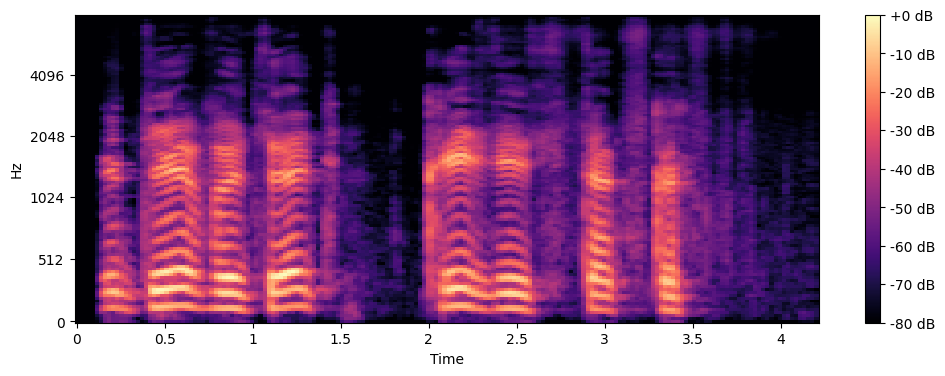

In [ ]:
# распаковка аудиоданных
with zipfile.ZipFile('/content/drive/MyDrive/speech_def.zip', 'r') as zip_ref:
  zip_ref.extractall('train')

df = pd.read_excel('/content/train/Speeches.xlsx', index_col='Число')

audio_file = '/content/train/Disorder Voices/Disorder Voices/10.wav'
samples, sample_rate = librosa.load(audio_file)
spectrogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate)

plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
new_path_defect = "/content/Train/Disorder Voices"
os.makedirs(new_path_defect, exist_ok=True)

new_path_normal = "/content/Train/Normal Voices"
os.makedirs(new_path_normal, exist_ok=True)

train_folder = "./train"

In [ ]:
# перемещение аудио в новую папку и создание спектограмм
for folder in os.listdir(train_folder):
  folder_path = os.path.join(train_folder, folder)
  if os.path.isdir(folder_path):
    folder_path = os.path.join(folder_path, folder)

    for fil in os.listdir(folder_path):
        fil_name = os.path.splitext(fil)[0]

        if folder == 'Disorder Voices':
          new_path = os.path.join(new_path_defect, fil_name)
        else:
          new_path = os.path.join(new_path_normal, fil_name)

        if not os.path.exists(new_path):
          filename = os.path.join(folder_path, fil)
          samples, sample_rate = librosa.load(filename)
          spectrogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
          librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max))
          os.makedirs(new_path)
          shutil.move(filename, new_path)
          plt.savefig(os.path.join(new_path, fil_name + '.png'), bbox_inches='tight', pad_inches=0)

In [ ]:
src_file = '/content/train/Speeches.xlsx'
dest_folder = '/content/Train'

shutil.move(src_file, dest_folder)

In [ ]:
# создание архива
def create_archive(output_path, *folders):
    with zipfile.ZipFile(output_path, 'w') as zipf:
        for folder in folders:
            for root, _, files in os.walk(folder):
                for fil in files:
                    file_path = os.path.join(root, fil)
                    arcname = os.path.relpath(file_path, folder)
                    zipf.write(file_path, arcname)

create_archive('TrainSpeech.zip', '/content/Train')

In [ ]:
src = '/content/TrainSpeech.zip'
dst = '/content/drive/MyDrive/Train.zip'

shutil.move(src, dst)

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Train.zip', 'r') as zip_ref:
  zip_ref.extractall('Train')

In [ ]:
class DisorderOrNormalDataset(Dataset):
    def __init__(self, filenames, transform):
        self.filenames = filenames
        self.labels = np.array([1 if 'Disorder ' in file else 0 for file in self.filenames], dtype = 'float32')
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        path = self.filenames[index]
        folder_name = os.path.basename(path)
        new_path = os.path.join(path, folder_name + ".png")
        spectrogram_image = Image.open(new_path)
        audio = self.transform(spectrogram_image)
        label = self.labels[index]
        audio_name = os.path.join(path, folder_name + ".wav")
        return audio, label, audio_name

In [ ]:
np.random.seed(0)
# torch.random.seed(0)
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def transform_funct(size_w=123, size_h=195):
    return transforms.Compose([
            transforms.Resize((size_w, size_h)),
            transforms.ToTensor()
            ])

In [ ]:
transform = transform_funct()

filenames = glob.glob('/content/Train/Train/Disorder Voices/*') + glob.glob('/content/Train/Train/Normal Voices/*')
filenames = np.random.permutation(filenames)

In [ ]:
N = len(filenames)
# 2800 в тренировочной выборке
batch_size = 28
train_dataset = DisorderOrNormalDataset(filenames[:int(N*0.7)], transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DisorderOrNormalDataset(filenames[int(N*0.7):], transform)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# https://libeldoc.bsuir.by/bitstream/123456789/44164/1/Prokopenya_Svertochnyye.pdf первая архитектура

In [ ]:
class NN_CNN(nn.Module):
    def __init__(self, input_size1=123, input_size2=195, num_conv_layers=1):
        super(NN_CNN, self).__init__()

        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, stride=1))
        for _ in range(num_conv_layers - 1):
            self.conv_layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding = 1))

        self.pooling_layer2 = nn.MaxPool2d(kernel_size=2)
        self.linear_layer1 = nn.Linear(in_features=32 * (input_size1//2-1) * (input_size2//2-1), out_features=32)
        self.linear_layer2 = nn.Linear(in_features=32, out_features=1)
        self.dropout = nn.Dropout(0.5)

        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()

        self.attention = ScaledDotProductAttention(32, 32)

    def forward(self, inputs):
        output = inputs
        for conv_layer in self.conv_layers:
            output = conv_layer(output)
        output = self.pooling_layer2(self.relu(output))

        output, w = self.attention(output)

        output = output.reshape(output.size(0), -1)

        output = self.relu(self.linear_layer1(output))
        output = self.dropout(output)
        output = self.sigm(self.linear_layer2(output))

        return output, w

class ScaledDotProductAttention(nn.Module):
    def __init__(self, input_dim, output_dim,  attn_dropout=32):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.attn_dropout = attn_dropout

        self.q = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1)
        self.k = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1)
        self.v = nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1)

        self.dropout = nn.Dropout()
        self.layer_norm = nn.LayerNorm(input_dim, eps=1e-6)


    def forward(self, x, mask=None):
        batch = x.shape[0]
        q_s = self.q(x).reshape(x.size(0), 32, 60*96)
        k_s = self.k(x).reshape(x.size(0), 32, 60*96)
        v_s = self.v(x).reshape(x.size(0), 32, 60*96)

        attn = torch.matmul(q_s, k_s.transpose(1, 2))/np.sqrt(self.attn_dropout)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v_s)
        return output, attn

In [ ]:
def TrainModdel(train_loader, model, optimizer, criterion, epohchs=1, step_print=20):
    total_step = len(train_loader)
    for epoch in range(1, epohchs+1):
        for step, (spektogram, label, _) in enumerate(train_loader, 1):

            outputs, _ = model(spektogram)
            loss = criterion(outputs, label.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (step) % step_print == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.5f}'
                      .format(epoch, epohchs, step, total_step, loss.item()))

In [ ]:
def accuracy_test(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for (spektogram, labels, _ ) in test_loader:
            outputs, _ = model(spektogram)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct +=  torch.eq(predicted, labels.unsqueeze(1)).sum().item()
        accuracy = correct / total
    return accuracy

In [ ]:
def plotAttention(data, model):
  with torch.no_grad():
    for (spektogram, labels, name) in data:
        pattern = '[0-9]*.wav'
        outputs, w = model(spektogram)
        if torch.round(outputs) == 1:
          label = 'Disorder voice'
        else:
          label = 'Normal voice'
        w = w.reshape(w.size(1), w.size(1))
        index_of_max_sum_column = np.argmax(w.sum(axis=0))
        duration = librosa.get_duration(path=name[0])
        start = (duration/w.size(-1)*index_of_max_sum_column)
        file_name = re.findall(pattern, name[0])[0]
        plt.imshow(w.detach().numpy().reshape(32, 32), cmap='coolwarm', label = name[0])
        plt.title('{} {}, Total time {:.3}, time {:.3}'.format(label, file_name, duration, start))
        # plt.colorbar()
        plt.show()
        print()

In [ ]:
model_1lay = NN_CNN().to(device)

criterion_1lay = nn.BCEWithLogitsLoss().to(device)
optimizer_1lay = torch.optim.AdamW(model_1lay.parameters(), lr=1e-4)

In [ ]:
TrainModdel(train_loader, model_1lay, optimizer_1lay, criterion_1lay, 1)

Epoch [1/1], Step [20/100], Loss: 0.67131
Epoch [1/1], Step [40/100], Loss: 0.60145
Epoch [1/1], Step [60/100], Loss: 0.63276
Epoch [1/1], Step [80/100], Loss: 0.66620
Epoch [1/1], Step [100/100], Loss: 0.56800


In [ ]:
# с attention 0.8617
accuracy_test(model_1lay, test_loader)

0.8775

In [ ]:
ssss = DisorderOrNormalDataset(filenames[:2], transform)
s = DataLoader(ssss, batch_size=1, shuffle=False)

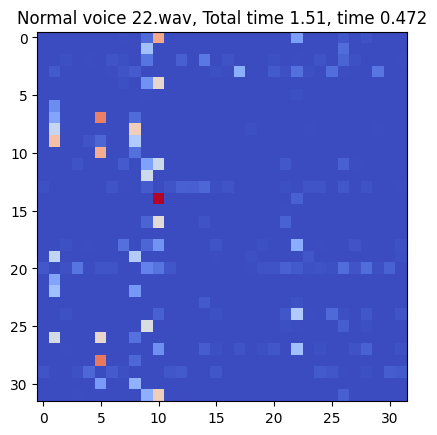

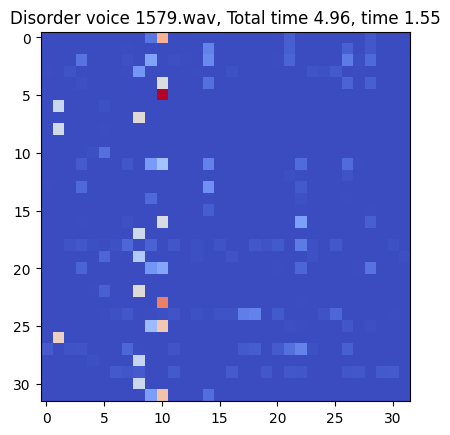

In [ ]:
plotAttention(s, model_1lay)

In [ ]:
model_2lay = NN_CNN(num_conv_layers=2).to(device)

criterion_2lay = nn.BCEWithLogitsLoss().to(device)
optimizer_2lay = torch.optim.AdamW(model_2lay.parameters(), lr=1e-4)

In [ ]:
TrainModdel(train_loader, model_2lay, optimizer_2lay, criterion_2lay, 1)

Epoch [1/1], Step [20/100], Loss: 0.68077
Epoch [1/1], Step [40/100], Loss: 0.65019
Epoch [1/1], Step [60/100], Loss: 0.57912
Epoch [1/1], Step [80/100], Loss: 0.53500
Epoch [1/1], Step [100/100], Loss: 0.46084


In [ ]:
# 0.99
accuracy_test(model_2lay, test_loader)

0.9783333333333334

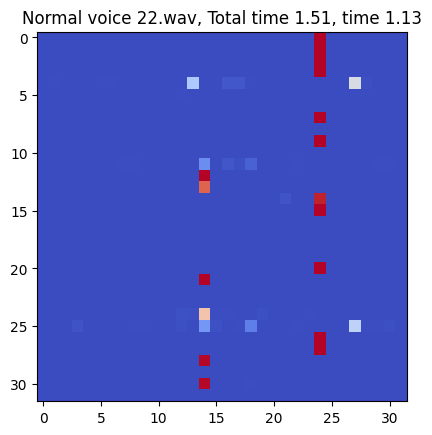

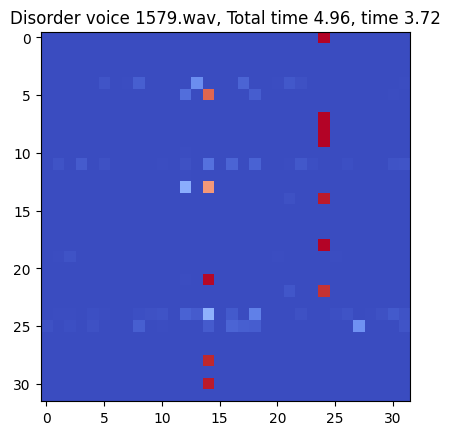

In [ ]:
plotAttention(s, model_2lay)

In [ ]:
model_3lay = NN_CNN(num_conv_layers=3).to(device)

criterion_3lay = nn.BCEWithLogitsLoss().to(device)
optimizer_3lay = torch.optim.AdamW(model_3lay.parameters(), lr=1e-4)

In [ ]:
TrainModdel(train_loader, model_3lay, optimizer_3lay, criterion_3lay, 5)

In [ ]:
# 0.
accuracy_test(model_3lay, test_loader)

1.0

In [ ]:
data, samplerate = sf.read('/content/Train/Train/Disorder Voices/130/130.wav')

silence_duration = samplerate * 1
silence = np.zeros((silence_duration, 2))
augmented_audio = np.concatenate((silence, data), axis=0)
sf.write('Изм130.wav', augmented_audio, samplerate)

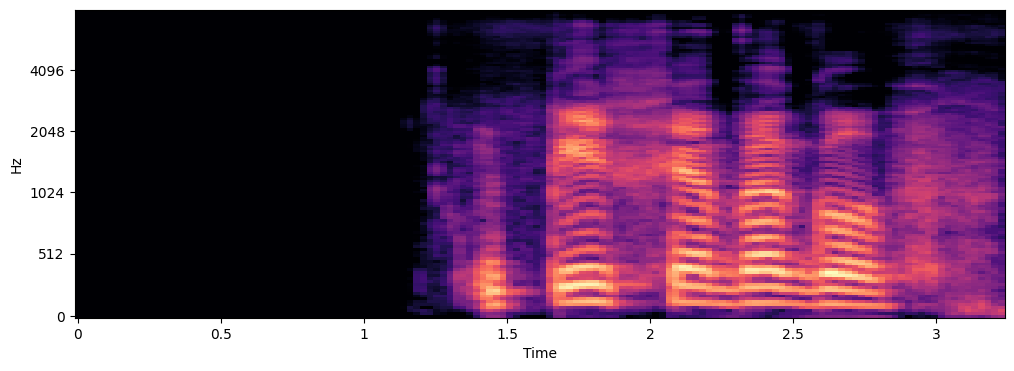

In [ ]:
samples, sample_rate = librosa.load('/content/Изм130.wav')
# samples, sample_rate = librosa.load('/content/Train/Train/Disorder Voices/130/130.wav')

spectrogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate)

plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.savefig('Изм130.png', bbox_inches='tight', pad_inches=0)
plt.show()

tensor([[1.2552e-06]])


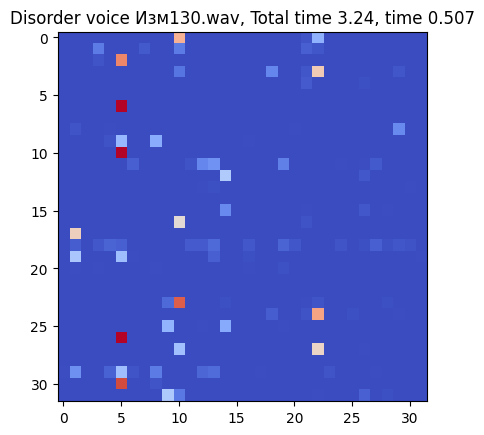

In [ ]:
with torch.no_grad():
  spectrogram_image = Image.open('/content/Изм130.png')
  audio = transform(spectrogram_image)
  # print(audio.unsqueeze(0).shape)
  pattern = '[0-9]*.wav'
  outputs, w = model_1lay(audio.unsqueeze(0))
  print(outputs)
  w = w.reshape(w.size(1), w.size(1))
  index_of_max_sum_column = np.argmax(w.sum(axis=0))
  duration = librosa.get_duration(path='/content/Изм130.wav')
  start = duration / 32 * index_of_max_sum_column
  # print(duration / 32 * index_of_max_sum_column, index_of_max_sum_column)
  # file_name = re.findall(pattern, 'Изм130.wav')[0]
  plt.imshow(w.detach().numpy().reshape(32, 32), cmap='coolwarm', label = 'Изм130.png')
  plt.title('{} {}, Total time {:.3}, time {:.3}'.format('Disorder voice', 'Изм130.wav', duration, start))
  plt.show()
  print()